<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'> 🌐 Styling, Links and Modules</h1>
---
#### [Keras. Applications](https://keras.io/applications/#inceptionv3)
#### [Extended version. Python](https://olgabelitskaya.github.io/kaggle_flowers.html) & [Extended version. R](https://olgabelitskaya.github.io/kaggle_flowers_R.html)
#### [Github Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP0) & [Colaboratory Version](https://colab.research.google.com/drive/1H2ArWH_1kYfkIoCbxleX-aHAozRVBAdB)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d'); 
a,h4 {color:slategray; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
span {color:black; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#ff355e;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}     
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,pylab as pl
import keras as ks,tensorflow as tf
import h5py,cv2; from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing import image as kimage
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import BatchNormalization,Conv2D,Dense
from keras.layers import LSTM,Flatten,Activation,Dropout
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.layers import MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as iv3pi
fpath='../input/flower-color-images/flower_images/flower_images/'
fw='weights.best.flowers.hdf5'
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0


In [3]:
def history_plot(fit_history):
    pl.figure(figsize=(12,9));pl.subplot(211)
    pl.plot(fit_history.history['loss'],
            color='slategray',label='train')
    pl.plot(fit_history.history['val_loss'],
            color='#ff355e',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')      
    pl.subplot(212)
    pl.plot(fit_history.history['acc'],
            color='slategray',label='train')
    pl.plot(fit_history.history['val_acc'], 
            color='#ff355e',label='valid')
    pl.xlabel('Epochs'); pl.ylabel('Accuracy')    
    pl.legend(); pl.title('Accuracy')
    pl.grid(); pl.show()
def path_to_tensor(img_path,fpath=fpath):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(128,128))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths):
    tensor_list=[path_to_tensor(img_path) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True 

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'> &#x1F310; &nbsp; Data Exploration</h1>

In [4]:
flowers=pd.read_csv(fpath+"flower_labels.csv")
flower_files=flowers['file']
flower_labels=flowers['label'].values
names=['phlox','rose','calendula','iris',
       'max chrysanthemum','bellflower','viola',
       'rudbeckia laciniata','peony','aquilegia']

In [5]:
# with h5py.File('../input/FlowerColorImages.h5','r') as f:
#     flower_images=f['images'].value
#     flower_labels=f['labels'].value 

Label:  4 max chrysanthemum


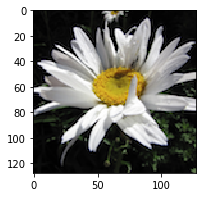

In [6]:
n=np.random.randint(0,210,1)[0]
print('Label: ',flower_labels[n],
      names[flower_labels[n]])
img=cv2.imread(fpath+flower_files[n])
rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pl.figure(figsize=(3,3))
pl.imshow(rgb_img);

In [7]:
flower_images=paths_to_tensor(flower_files)/255
flower_labels=to_categorical(flower_labels,10)

100%|██████████| 210/210 [00:00<00:00, 224.15it/s]


In [8]:
x_train,x_test,y_train,y_test=\
train_test_split(flower_images,flower_labels,
                 test_size=.2,random_state=1)
m=int(len(x_test)/2)
x_valid,y_valid=x_test[:m],y_test[:m]
x_test,y_test=x_test[m:],y_test[m:]
[x_train.shape,x_test.shape,x_valid.shape,
 y_train.shape,y_test.shape,y_valid.shape]

[(168, 128, 128, 3),
 (21, 128, 128, 3),
 (21, 128, 128, 3),
 (168, 10),
 (21, 10),
 (21, 10)]

Label:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] peony


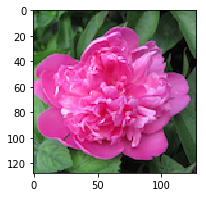

In [9]:
n=np.random.randint(0,168,1)[0]
print('Label: ',y_train[n],
      names[np.argmax(y_train[n])])
pl.figure(figsize=(3,3))
pl.imshow((x_train[n]));

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'> &#x1F310; &nbsp; Classification Models</h1>

In [10]:
def mlp_model():
    model=Sequential()    
    model.add(Dense(128,activation='relu',
                    input_shape=(128*128*3,)))
    model.add(BatchNormalization())    
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())    
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())   
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))     
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',metrics=['accuracy'])
    return model
mlp_model=mlp_model()

In [11]:
early_stopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,
                               patience=5,factor=.8)
history=mlp_model.fit(x_train.reshape(-1,128*128*3),y_train,
                      epochs=100,batch_size=64,verbose=2,
                      validation_data=(x_valid.reshape(-1,128*128*3),y_valid),
                      callbacks=[checkpointer,early_stopping,lr_reduction])

Train on 168 samples, validate on 21 samples
Epoch 1/100
 - 2s - loss: 2.4820 - acc: 0.1488 - val_loss: 4.6056 - val_acc: 0.1905

Epoch 00001: val_loss improved from inf to 4.60558, saving model to weights.best.flowers.hdf5
Epoch 2/100
 - 0s - loss: 1.2718 - acc: 0.6190 - val_loss: 3.9501 - val_acc: 0.2857

Epoch 00002: val_loss improved from 4.60558 to 3.95007, saving model to weights.best.flowers.hdf5
Epoch 3/100
 - 0s - loss: 0.5922 - acc: 0.8155 - val_loss: 5.9203 - val_acc: 0.1429

Epoch 00003: val_loss did not improve
Epoch 4/100
 - 0s - loss: 0.2380 - acc: 0.9524 - val_loss: 6.9926 - val_acc: 0.1429

Epoch 00004: val_loss did not improve
Epoch 5/100
 - 0s - loss: 0.1007 - acc: 0.9881 - val_loss: 7.1292 - val_acc: 0.1429

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 0s - loss: 0.0843 - acc: 0.9940 - val_loss: 7.2283 - val_acc: 0.1905

Epoch 00006: val_loss did not improve
Epoch 7/100
 - 0s - loss: 0.0381 - acc: 1.0000 - val_loss: 6.9266 - val_acc: 0.1905

Epoch 00007: val

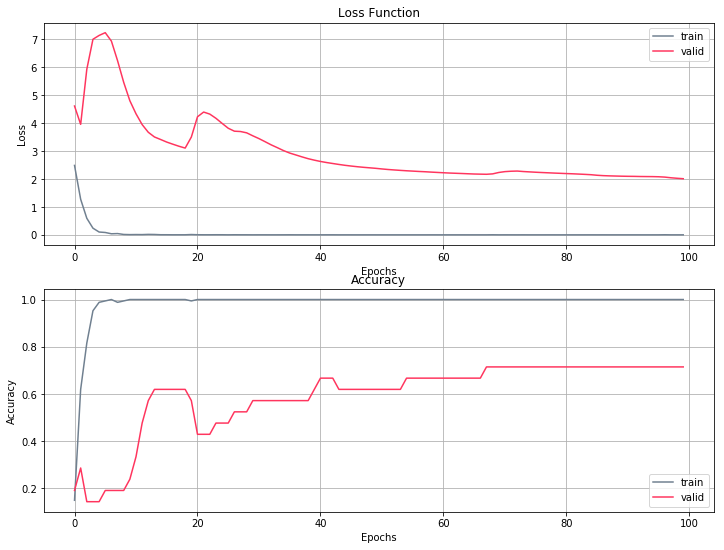

21/21 [==============================] - 0s 517us/step


[1.768310546875, 0.4761904776096344]

In [12]:
history_plot(history)
mlp_model.load_weights(fw)
mlp_model.evaluate(x_test.reshape(-1,128*128*3),y_test)

In [13]:
def cnn_model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Conv2D(96,(5,5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(512,activation='tanh'))
    model.add(Dropout(.25))     
#    model.add(Dense(256,activation='tanh'))
#    model.add(Dropout(.25))     
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(.25)) 
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])    
    return model
cnn_model=cnn_model()

In [14]:
early_stopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,
                               patience=5,factor=.8)
history=cnn_model.fit(x_train,y_train,epochs=100,batch_size=16,
                      verbose=2,validation_data=(x_valid,y_valid),
                      callbacks=[checkpointer,early_stopping,lr_reduction])

Train on 168 samples, validate on 21 samples
Epoch 1/100
 - 9s - loss: 2.2991 - acc: 0.1190 - val_loss: 2.4775 - val_acc: 0.0476

Epoch 00001: val_loss improved from inf to 2.47749, saving model to weights.best.flowers.hdf5
Epoch 2/100
 - 8s - loss: 2.2084 - acc: 0.1488 - val_loss: 2.0823 - val_acc: 0.0952

Epoch 00002: val_loss improved from 2.47749 to 2.08230, saving model to weights.best.flowers.hdf5
Epoch 3/100
 - 8s - loss: 1.9701 - acc: 0.2976 - val_loss: 1.9681 - val_acc: 0.2381

Epoch 00003: val_loss improved from 2.08230 to 1.96810, saving model to weights.best.flowers.hdf5
Epoch 4/100
 - 11s - loss: 1.8098 - acc: 0.3333 - val_loss: 1.7713 - val_acc: 0.2381

Epoch 00004: val_loss improved from 1.96810 to 1.77128, saving model to weights.best.flowers.hdf5
Epoch 5/100
 - 17s - loss: 1.6895 - acc: 0.3810 - val_loss: 1.9736 - val_acc: 0.1429

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 9s - loss: 1.4942 - acc: 0.4940 - val_loss: 1.8683 - val_acc: 0.1905

Epoch 00006: val_

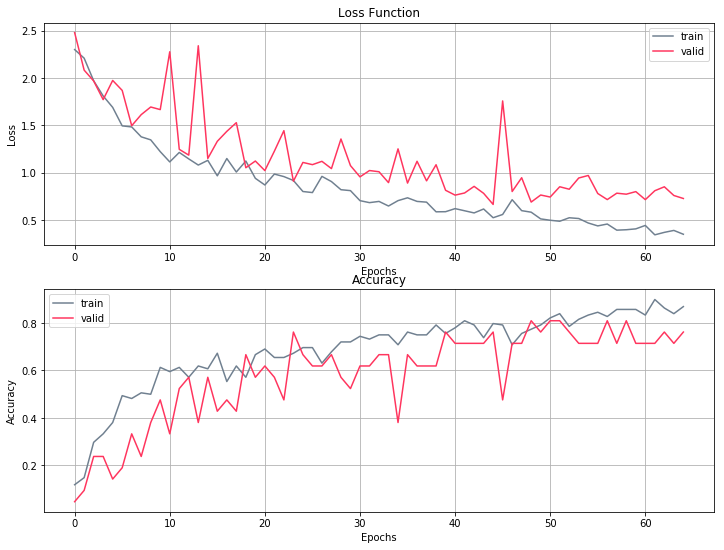

21/21 [==============================] - 0s 16ms/step


[0.6576324701309204, 0.8571428656578064]

In [15]:
history_plot(history)
cnn_model.load_weights(fw)
cnn_model.evaluate(x_test,y_test)

In [16]:
'''
generator=kimage.\
ImageDataGenerator(shear_range=.3,zoom_range=.3,
                   rotation_range=30,horizontal_flip=True)
ghistory=cnn_model.fit_generator(generator\
.flow(x_train,y_train,batch_size=64),\
steps_per_epoch=189,epochs=3,verbose=2,\
validation_data=(x_valid,y_valid),
callbacks=[checkpointer,early_stopping,lr_reduction])
'''
''' '''

' '

In [17]:
'''
cnn_model.load_weights(fw)
cnn_model.evaluate(x_test,y_test)
'''
''' '''

' '

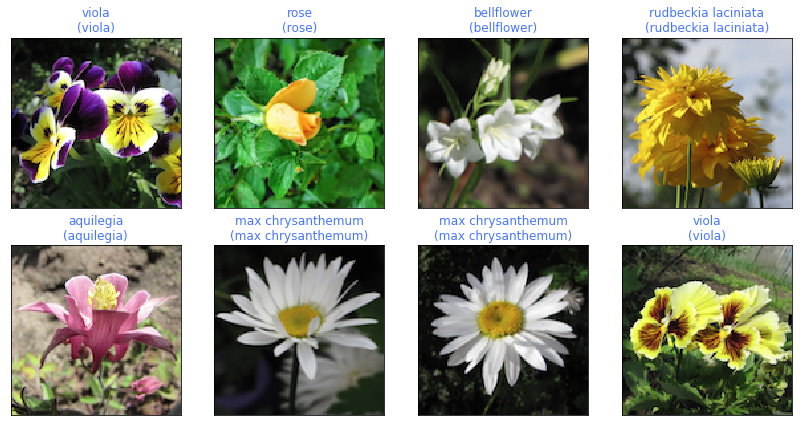

In [18]:
y_test_predict=cnn_model.predict_classes(x_test)
fig=pl.figure(figsize=(14,7))
randch=np.random.choice(x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=np.argmax(y_test[idx])
    ax.set_title("{}\n({})".format(names[pred_idx],names[true_idx]),
                 color=("#4876ff" if pred_idx==true_idx else "darkred"))
pl.show()

In [19]:
def rnn_model():
    model=Sequential()
    model.add(LSTM(196,return_sequences=True,
                   input_shape=(1,128*128*3))) 
    model.add(LSTM(196,return_sequences=True))
    model.add(LSTM(196))  
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])    
    return model
rnn_model=rnn_model()

In [20]:
early_stopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,
                               patience=5,factor=.8)
history=rnn_model.fit(x_train.reshape(-1,1,128*128*3),y_train,
                      epochs=100,batch_size=64,verbose=2,
                      validation_data=(x_valid.reshape(-1,1,128*128*3),y_valid),
                      callbacks=[checkpointer,early_stopping,lr_reduction])

Train on 168 samples, validate on 21 samples
Epoch 1/100
 - 7s - loss: 2.3021 - acc: 0.1012 - val_loss: 2.2978 - val_acc: 0.1429

Epoch 00001: val_loss improved from inf to 2.29782, saving model to weights.best.flowers.hdf5
Epoch 2/100
 - 3s - loss: 2.2878 - acc: 0.1369 - val_loss: 2.2849 - val_acc: 0.1429

Epoch 00002: val_loss improved from 2.29782 to 2.28487, saving model to weights.best.flowers.hdf5
Epoch 3/100
 - 3s - loss: 2.2673 - acc: 0.1369 - val_loss: 2.2573 - val_acc: 0.1429

Epoch 00003: val_loss improved from 2.28487 to 2.25732, saving model to weights.best.flowers.hdf5
Epoch 4/100
 - 3s - loss: 2.2304 - acc: 0.1369 - val_loss: 2.2178 - val_acc: 0.1429

Epoch 00004: val_loss improved from 2.25732 to 2.21782, saving model to weights.best.flowers.hdf5
Epoch 5/100
 - 3s - loss: 2.1595 - acc: 0.2083 - val_loss: 2.1583 - val_acc: 0.1905

Epoch 00005: val_loss improved from 2.21782 to 2.15826, saving model to weights.best.flowers.hdf5
Epoch 6/100
 - 3s - loss: 2.0663 - acc: 0.22

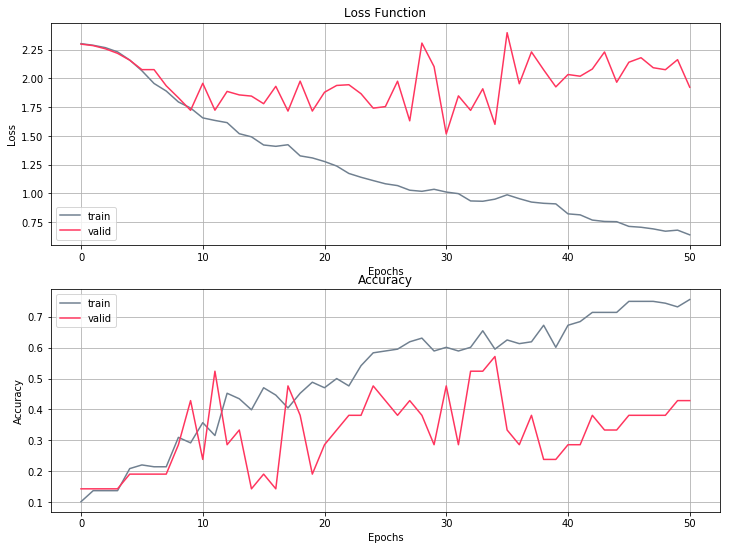

21/21 [==============================] - 0s 4ms/step


[1.845196008682251, 0.3333333432674408]

In [21]:
history_plot(history)
rnn_model.load_weights(fw)
rnn_model.evaluate(x_test.reshape(-1,1,128*128*3),y_test)